# For explaination go to the last cell

In [1]:
%matplotlib inline
import random
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras



In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import tensorflow_datasets as tfds

In [3]:
splits, info = tfds.load('eurosat', with_info=True, as_supervised=True, split = ['train[:80%]' , 'train[80%:90%]' ,'train[90%:]' ])

(train_examples, validation_examples, test_examples) = splits

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incomplete7TIC3M/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [4]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
print(num_classes)

10


In [5]:
get_label_name = info.features['label'].int2str
class_names = [get_label_name(i) for i in range(0,num_classes)]
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


In [6]:
## if you wish to work with tensorflow v1 then ask it to emulate version 2 behavior
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
print(tf.__version__)

## check hardware availability
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.4.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16599540688858326868
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14638920512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2384028295170356251
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [7]:
### load the data  


train_images, train_labels = tuple(zip(*train_examples)) 
train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images, test_labels = tuple(zip(*validation_examples)) 
test_images = np.array(test_images)
test_labels = np.array(test_labels)



num_classes = len(class_names)
## Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

X_train = train_images
X_test = test_images
y_train = train_labels
y_test = test_labels

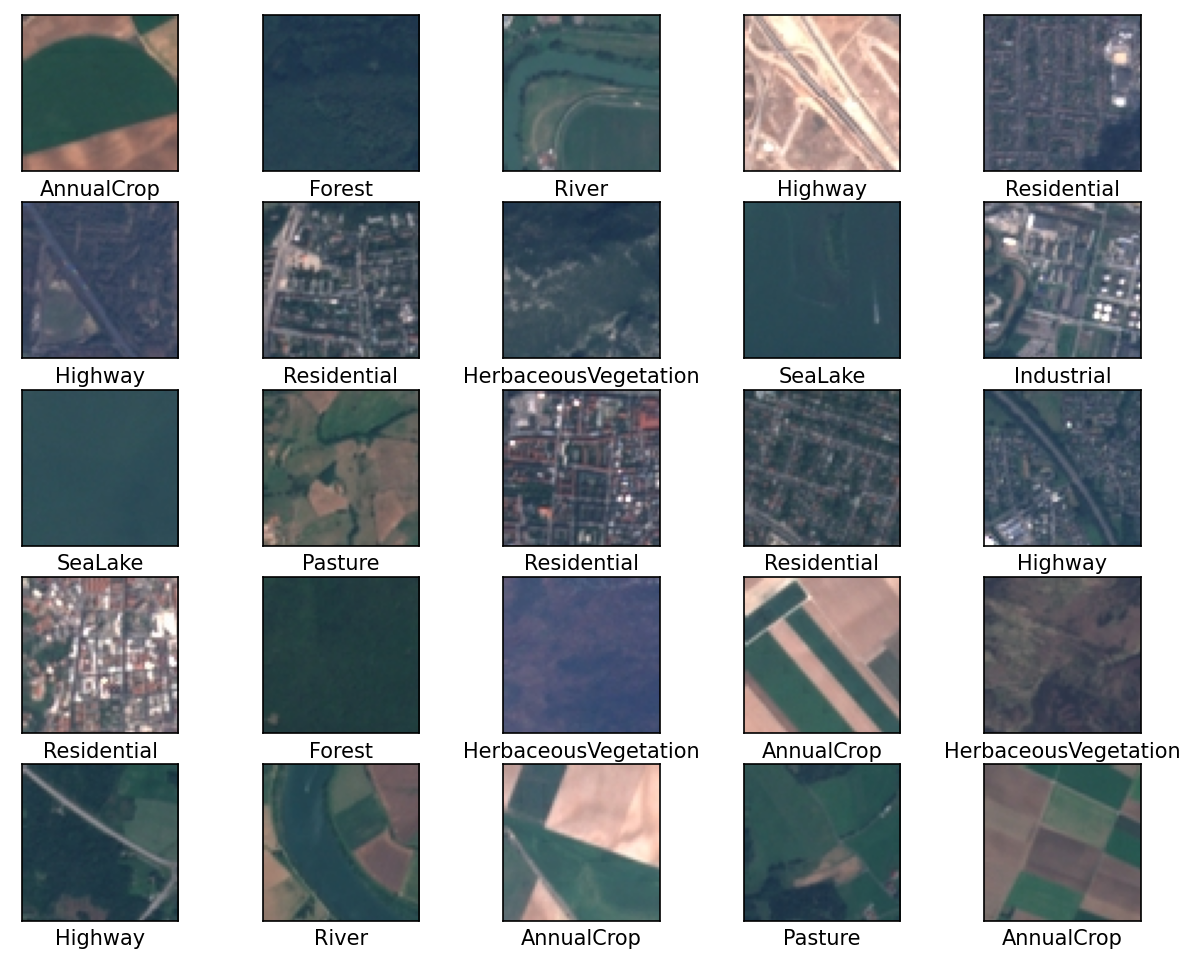

In [8]:
## YOUR CODE HERE (visualization code)

def show_img(img_ind):
    fig = plt.figure(figsize=(6,4),dpi=150,facecolor='white')
    ax = fig.add_subplot(111)

    ax.imshow(train_images[img_ind])
    ax.grid(False)
    ax.set_title(class_names[train_labels[img_ind]])
    
fig = plt.figure(figsize=(10,8),dpi=150,facecolor='white')
offset = 25
for i in range(25):
    ax = fig.add_subplot(5,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.imshow(train_images[i+offset], cmap=plt.cm.binary)
    ax.set_xlabel(class_names[int(train_labels[i+offset])])

In [9]:
## YOUR CODE HERE (Summarize the data)
from collections import Counter
print("-------------------------------------------")
print("X_train: {}".format(X_train.shape))
class_info = list(sorted(Counter(y_train).items()))
print("num classes: {}, classes: {}".format(len(class_info), [i[0] for i in class_info]))
print("class samples: {}".format([i[1] for i in class_info]))
print("class balance: {} %".format([round(i[1]/X_train.shape[0]*100,2) for i in class_info]))
print("-------------------------------------------")


-------------------------------------------
X_train: (21600, 64, 64, 3)
num classes: 10, classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
class samples: [2405, 2383, 2365, 2001, 1992, 1626, 2004, 2420, 2018, 2386]
class balance: [11.13, 11.03, 10.95, 9.26, 9.22, 7.53, 9.28, 11.2, 9.34, 11.05] %
-------------------------------------------


In [10]:
## YOUR CODE HERE (Replace the symbole #<> with your code)

# First we flatten the images to have a data shape that can be ingested by the PCA model.
# Take a moment to understand what does this function (flatten()) do to the images 
# and why this step is necessary.
X_train_flat = np.array([i.flatten() for i in train_images])
print(X_train_flat.shape)
X_test_flat = np.array([i.flatten() for i in test_images])
print(X_test_flat.shape)

(21600, 12288)
(2700, 12288)


In [11]:
from sklearn.manifold import TSNE

# The default of 1,000 iterations gives fine results, but I'm training for longer just 
# out some marginal improvements. NB: This takes almost an hour!

tsne = TSNE(random_state=1, n_iter=3000, metric="cosine", n_components= 2 , perplexity= 50.0)
embs = tsne.fit_transform(X_train_flat)

In [13]:
labeling = [class_names[i] for i in y_train]

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


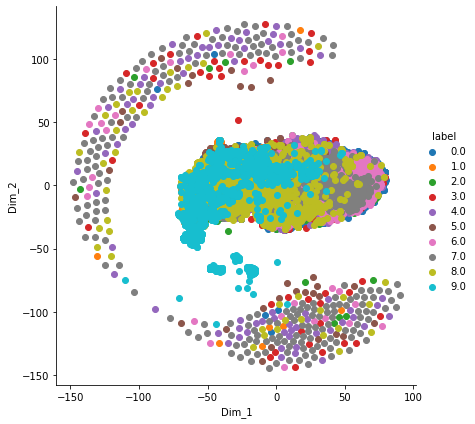

In [15]:
# creating a new data frame which help us in ploting the result data
import seaborn as sns
tsne_data = np.vstack((embs.T, y_train)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=('Dim_1', 'Dim_2', 'label'))
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue='label', size=6,).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

In [16]:
tsne_df.groupby('label').head(10)

,Dim_1,Dim_2,label
0,-45.982014,-24.293383,9.0
1,-52.307201,3.269411,1.0
2,29.181061,-3.963156,3.0
3,-5.304946,18.360519,7.0
4,-6.806644,14.197983,8.0
...,...,...,...
116,-32.107586,-22.560188,4.0
124,-36.035557,21.697760,5.0
126,-29.162899,-56.627132,9.0
134,-43.563469,24.719076,5.0


# T-SNE (t distributed stocastic nearest neighboor algo):
## Mathematical link :

https://www.techfak.uni-bielefeld.de/~fschleif/mlr/mlr_02_2010.pdf

## Simple Explaination :
https://medium.com/swlh/t-sne-explained-math-and-intuition-94599ab164cf#:~:text=The%20method%20of%20t%2Ddistributed,therefore%20it%20is%20highly%20popular.



##Video explaination :
##Statsque:
https://www.youtube.com/watch?v=NEaUSP4YerM

## original paper :
https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf

Bullet points :

- its a dimentionality reduction technique .

- its a non-parametric , so , cannot be re-used for another dataset.

- its a unsupervised algorithim .

- Parameters in the model:-   There are several parameters in this model that you can adjust to your needs. Some of them relate to the process of gradient descent, where the most important ones are the learning rate and the number of iterations. If you are not familiar with gradient descent I recommend going through its explanation for better understanding.
Another parameter in t-SNE is perplexity. It is used for choosing the standard deviation σᵢ of the Gaussian representing the conditional distribution in the high-dimensional space. I will not elaborate on the math behind it, but it can be interpreted as the number of effective neighbors for each point. The model is rather robust for perplexities between 5 to 50, but you can see some examples of how changes in perplexity affect t-SNE results in the following article.

- Reason for using t-dist  is to for its property of heavier  tails, so that the datapoints are more spreaded out in the lower dimension. 
- Keywords : t-distribution, conditional probability , gradient , const functino , gaussian distribution , dimentionalisty reduction, perplexity 

